In [42]:
from statsmodels.tsa.stattools import acf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('/content/household_power_consumption.txt', sep=';', header=0)

<ipython-input-2-3557073544>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/household_power_consumption.txt', sep=';', header=0)


In [ ]:
df

In [3]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.drop(columns=['Date', 'Time'], inplace=True)

In [4]:
df = df.sort_values(by='Datetime', ascending=True)

In [5]:
df.replace('?', np.nan, inplace=True)

In [6]:
columns_to_convert = df.select_dtypes(exclude=['datetime']).columns
df[columns_to_convert] = df[columns_to_convert].astype(float)
df = df.interpolate(method='linear')

In [7]:
df = df[['Datetime', 'Global_reactive_power']][:2000]

Нормализация

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Global_reactive_power'].values.reshape(-1, 1))
# reshape(-1, 1) необходим, так как MinMaxScaler ожидает 2D массив (samples, features)

# Графики

In [ ]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(df['Datetime'], df['Global_intensity'], marker='o')
plt.title('Global_active_power')
plt.xlabel('Время')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(df['Datetime'], df['Global_active_power'], marker='o')
plt.title('Global_active_power')
plt.xlabel('Время')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(df['Datetime'], df['Global_reactive_power'], marker='o')
plt.title('Global_reactive_power')
plt.xlabel('Время')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
lags = 100  # Количество лагов для анализа
acf_values = acf(df['Global_reactive_power'], nlags=lags)

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(range(lags + 1), acf_values, color='yellow')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.title('Автокорреляционная функция')
plt.show()

# Проверка на стационарность

In [9]:
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dfoutput['p-value'] <= 0.05:
        print("Ряд стационарен (отвергаем нулевую гипотезу)")
    else:
        print("Ряд нестационарен (не отвергаем нулевую гипотезу)")

In [10]:
print("До дифференцирования:")
test_stationarity(df['Global_reactive_power'])

До дифференцирования:
Результаты теста Дики-Фуллера:
Test Statistic                   -4.944067
p-value                           0.000029
#Lags Used                       24.000000
Number of Observations Used    1975.000000
Critical Value (1%)              -3.433665
Critical Value (5%)              -2.863005
Critical Value (10%)             -2.567550
dtype: float64
Ряд стационарен (отвергаем нулевую гипотезу)


In [ ]:
diff_data = df['Global_reactive_power'].diff().dropna()

# LSTM

In [12]:
# Формируем входные и выходные данные
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [13]:
train_size = int(len(X) * 0.8) # Например, 80% для обучения
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Форма X_train: {X_train.shape}") # (количество_тренировочных_образцов, sequence_length, 1)
print(f"Форма y_train: {y_train.shape}") # (количество_тренировочных_образцов,)
print(f"Форма X_test: {X_test.shape}")   # (количество_тестовых_образцов, sequence_length, 1)
print(f"Форма y_test: {y_test.shape}")   # (количество_тестовых_образцов,)

Форма X_train: (1552, 60, 1)
Форма y_train: (1552, 1)
Форма X_test: (388, 60, 1)
Форма y_test: (388, 1)


In [14]:
model_lstm = Sequential()

model_lstm.add(LSTM(50, activation='relu', return_sequences=True,
              input_shape=(seq_length, 1)))

model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(LSTM(50))

model_lstm.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Компилируем модель
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.summary()
# Обучаем модель
model_lstm.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0398 - val_loss: 0.0275
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0205 - val_loss: 0.0213
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0145 - val_loss: 0.0132
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0126 - val_loss: 0.0107
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0123 - val_loss: 0.0103
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0114 - val_loss: 0.0084
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0092 - val_loss: 0.0070
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0079 - val_loss: 0.0043
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0059 - val_loss: 0.0066
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0

In [16]:
# Делаем прогноз
y_pred_lstm = model_lstm.predict(X_test)

# Возвращаем данные в исходный масштаб
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

#print(y_pred_rescaled[:10])  # Вывод первых предсказанных значений

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [17]:
# Для визуализации нам нужны значения в исходном диапазоне
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm)

# Сначала получаем индексы для всего X и y
full_y_indices = df['Global_reactive_power'].index[seq_length:]

# Теперь разделяем индексы так же, как X и y
train_indices = full_y_indices[:train_size]
test_indices = full_y_indices[train_size:]

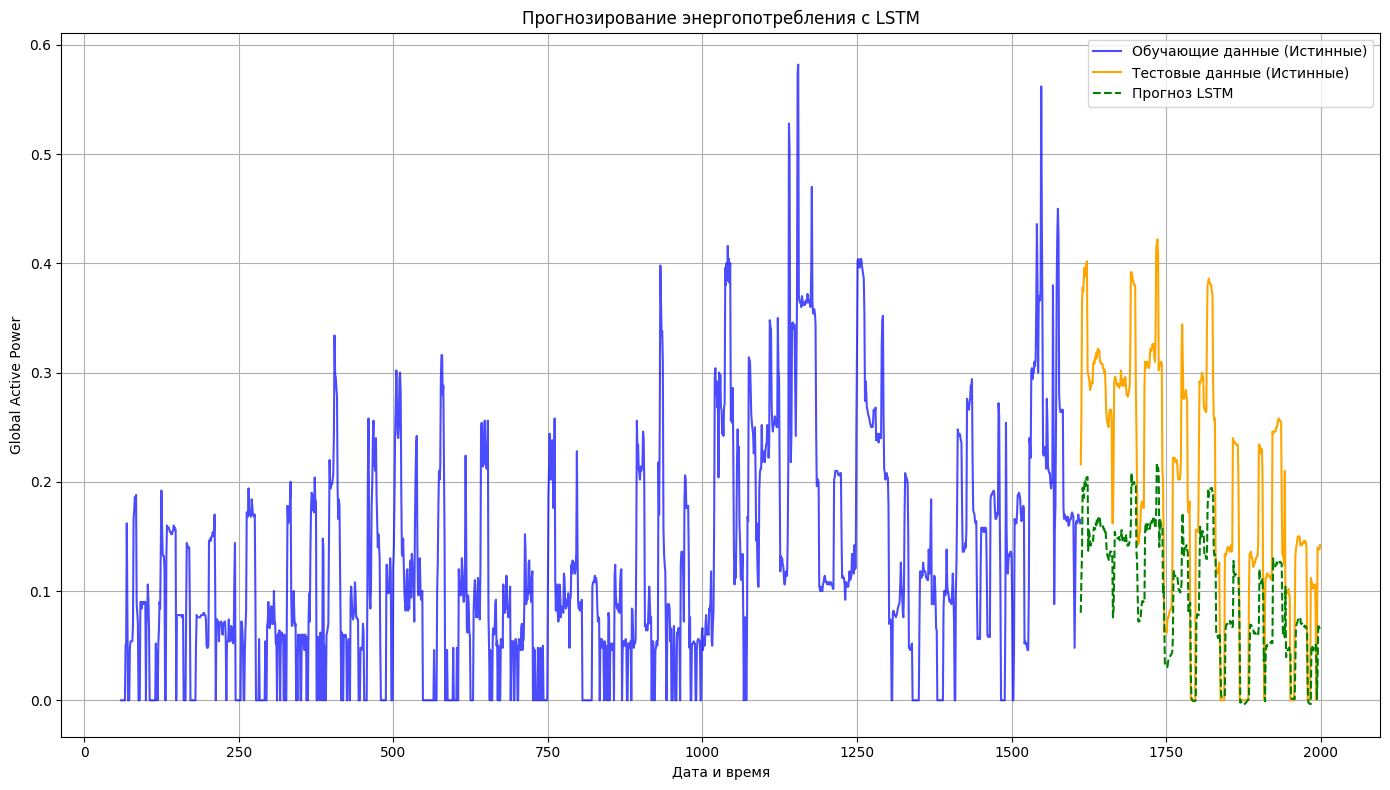

RMSE на тестовой выборке (в исходном масштабе): 0.1152


In [18]:
#Построение графика
plt.figure(figsize=(14, 8)) # Увеличенный размер для лучшей читаемости

# График обучающих данных (необязательно, но полезно для контекста)
# Обратно масштабируем y_train для отображения
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
plt.plot(train_indices, y_train_original, label='Обучающие данные (Истинные)', color='blue', alpha=0.7)

# График истинных тестовых данных
plt.plot(test_indices, y_test_original, label='Тестовые данные (Истинные)', color='orange')

# График предсказаний LSTM
plt.plot(test_indices, y_pred_lstm_original, label='Прогноз LSTM', color='green', linestyle='--')

plt.title('Прогнозирование энергопотребления с LSTM')
plt.xlabel('Дата и время')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.tight_layout() # Автоматическая настройка параметров графика для плотной компоновки
plt.show()

# Оценка RMSE на оригинальных данных
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_lstm_original))
print(f"RMSE на тестовой выборке (в исходном масштабе): {rmse:.4f}")

# GRU

In [19]:
model_gru = Sequential()

model_gru.add(GRU(50, activation='relu', return_sequences=True,
              input_shape=(seq_length, 1)))

model_gru.add(GRU(50, return_sequences=True))
model_gru.add(GRU(50))

model_gru.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model_gru.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - loss: 0.0237 - val_loss: 0.0112
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0065 - val_loss: 0.0047
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - lo

In [22]:
y_pred_gru = model_gru.predict(X_test)

y_pred_gru = scaler.inverse_transform(y_pred_gru)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [23]:
y_pred_gru_original = scaler.inverse_transform(y_pred_gru)

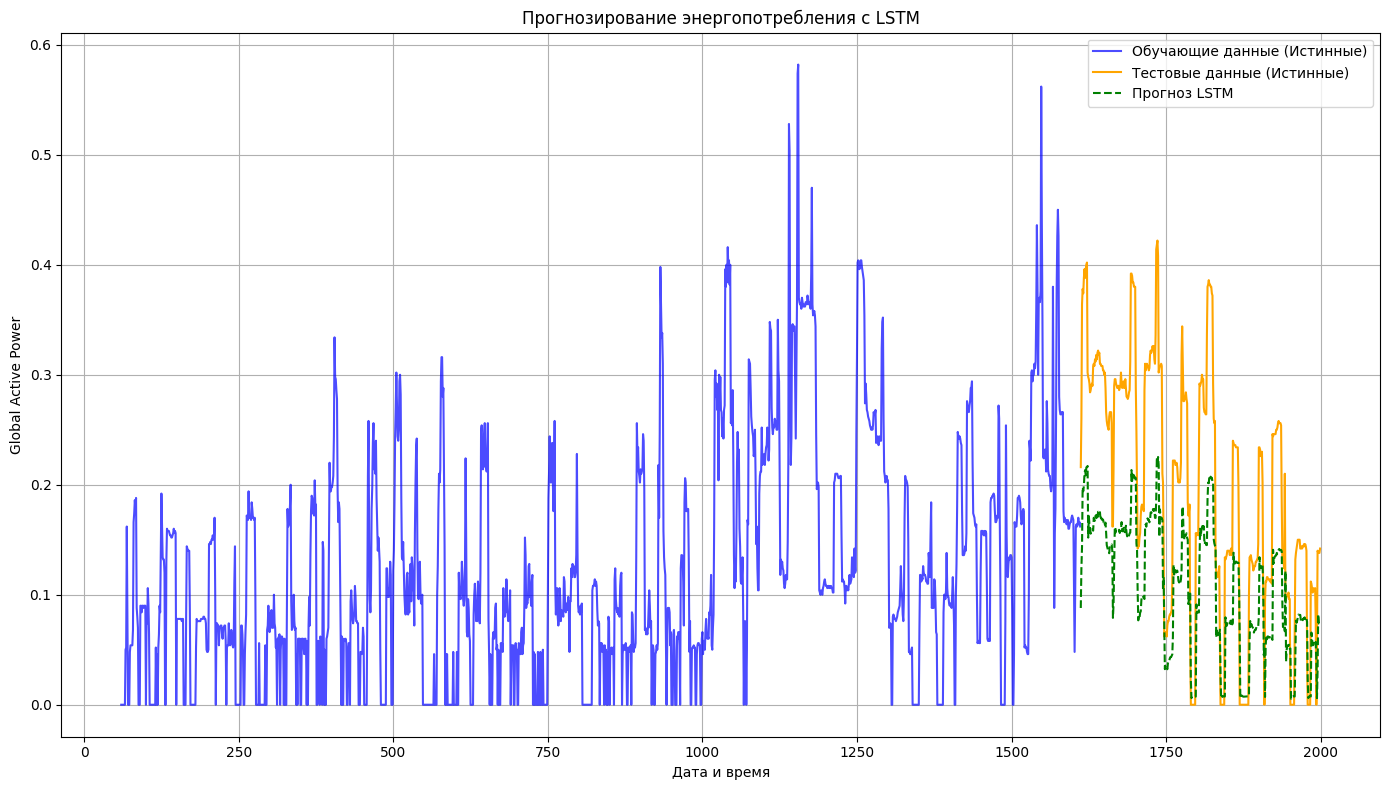

RMSE на тестовой выборке (в исходном масштабе): 0.1068


In [24]:
plt.figure(figsize=(14, 8)) # Увеличенный размер для лучшей читаемости

# График обучающих данных (необязательно, но полезно для контекста)
# Обратно масштабируем y_train для отображения
#y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
plt.plot(train_indices, y_train_original, label='Обучающие данные (Истинные)', color='blue', alpha=0.7)

# График истинных тестовых данных
plt.plot(test_indices, y_test_original, label='Тестовые данные (Истинные)', color='orange')

# График предсказаний LSTM
plt.plot(test_indices, y_pred_gru_original, label='Прогноз LSTM', color='green', linestyle='--')

plt.title('Прогнозирование энергопотребления с LSTM')
plt.xlabel('Дата и время')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.tight_layout() # Автоматическая настройка параметров графика для плотной компоновки
plt.show()

# Оценка RMSE на оригинальных данных
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_gru_original))
print(f"RMSE на тестовой выборке (в исходном масштабе): {rmse:.4f}")

# SimpleRNN

In [ ]:
# Изменение формы X для соответствия требованию RNN
# [количество_образцов, длина_последовательности, количество_признаков]
#X = X.reshape(X.shape[0], X.shape[1], 1) # 1, так как у нас 1 признак (Global_active_power)
# y уже в нужном формате, но если y был бы 2D (многошаговый прогноз), его тоже нужно reshape

In [25]:
model_srnn = Sequential()

model_srnn.add(SimpleRNN(50, activation='relu', return_sequences=True,
              input_shape=(seq_length, 1)))

model_srnn.add(SimpleRNN(50, return_sequences=True))
model_srnn.add(SimpleRNN(50))

model_srnn.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model_srnn.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
model_srnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.1702 - val_loss: 0.0192
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0138 - val_loss: 0.0095
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0057 - val_loss: 0.0070
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

In [28]:
y_pred_srnn = model_srnn.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [29]:
y_pred_srnn_original = scaler.inverse_transform(y_pred_srnn)

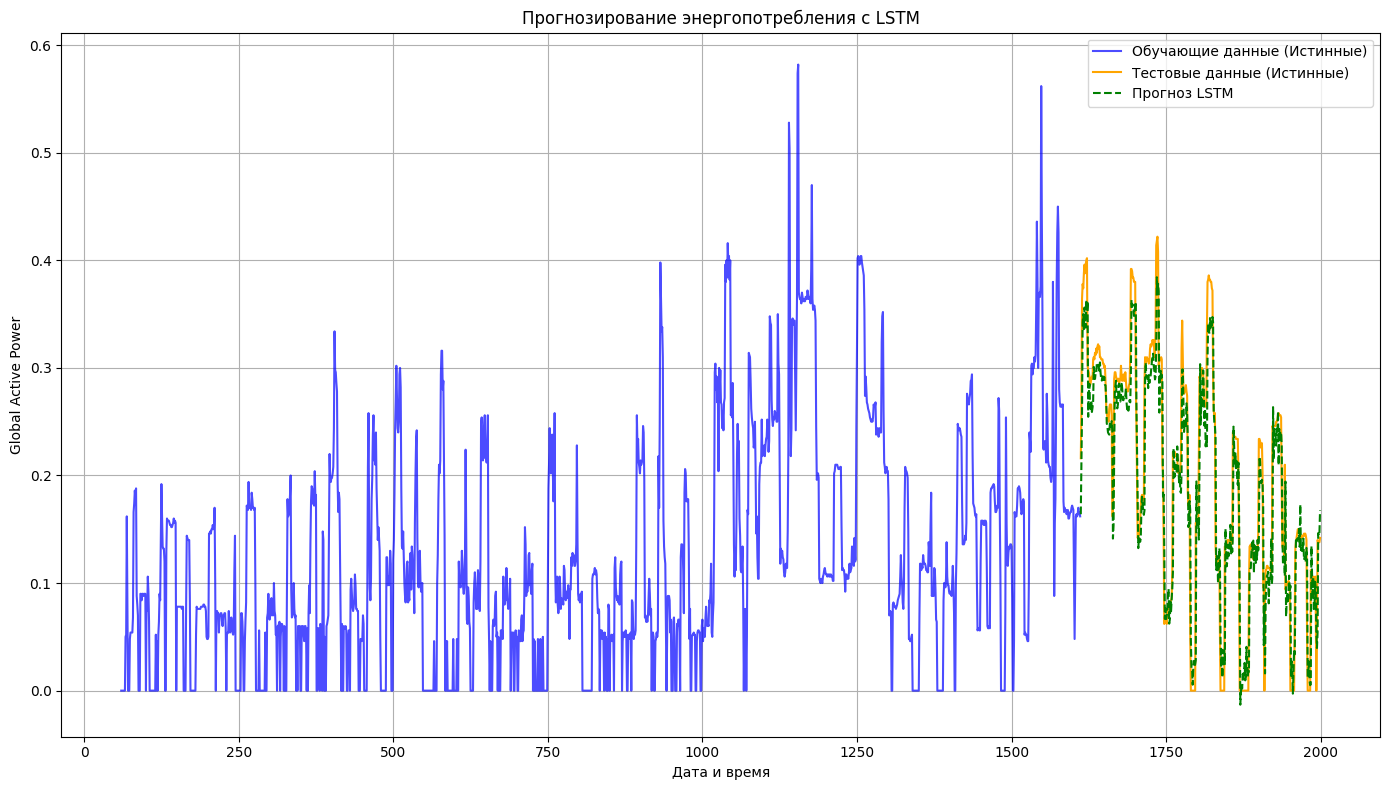

RMSE на тестовой выборке (в исходном масштабе): 0.0360


In [30]:
plt.figure(figsize=(14, 8)) # Увеличенный размер для лучшей читаемости

# График обучающих данных
plt.plot(train_indices, y_train_original, label='Обучающие данные (Истинные)', color='blue', alpha=0.7)

# График истинных тестовых данных
plt.plot(test_indices, y_test_original, label='Тестовые данные (Истинные)', color='orange')

# График предсказаний LSTM
plt.plot(test_indices, y_pred_srnn_original, label='Прогноз LSTM', color='green', linestyle='--')

plt.title('Прогнозирование энергопотребления с LSTM')
plt.xlabel('Дата и время')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.tight_layout() # Автоматическая настройка параметров графика для плотной компоновки
plt.show()

# Оценка RMSE на оригинальных данных
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_srnn_original))
print(f"RMSE на тестовой выборке (в исходном масштабе): {rmse:.4f}")

# ARIMA

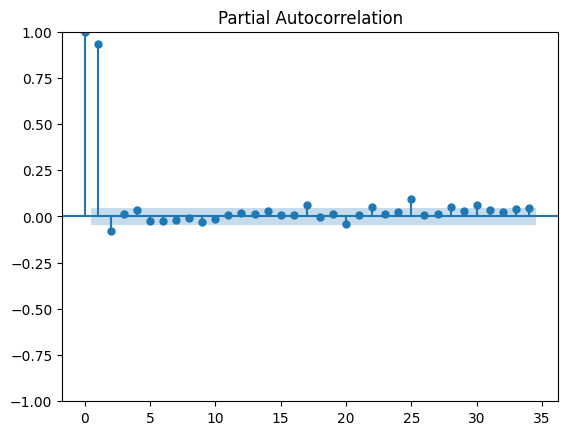

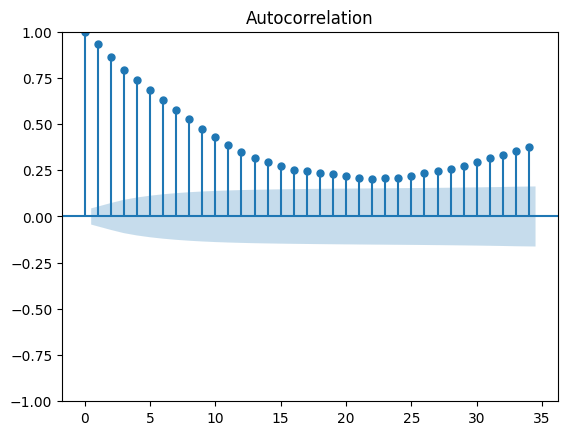

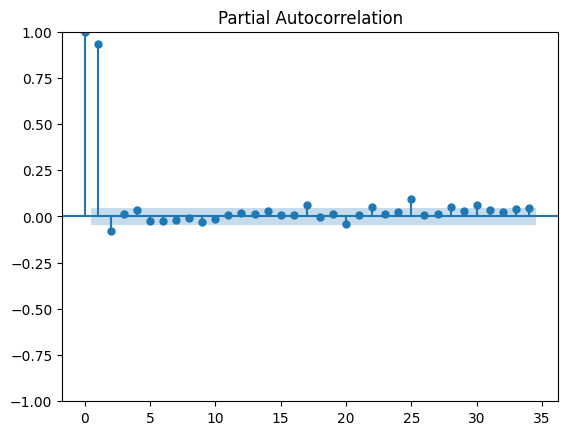

In [31]:
plot_acf(df['Global_reactive_power'])  # для выбора q
plot_pacf(df['Global_reactive_power'])

In [32]:
train_size = int(len(df) * 0.8)
train_data_arima, test_data_arima = df[0:train_size], df[train_size:]

In [43]:
scaled_data_train = scaler.fit_transform(train_data_arima['Global_reactive_power'].values.reshape(-1, 1))
scaled_data_test = scaler.fit_transform(test_data_arima['Global_reactive_power'].values.reshape(-1, 1))

In [44]:
arima_order = (1, 1, 1) # (p, d, q)
model = ARIMA(scaled_data_train, order=arima_order)
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1600
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1956.848
Date:                Thu, 12 Jun 2025   AIC                          -3907.696
Time:                        12:30:15   BIC                          -3891.565
Sample:                             0   HQIC                         -3901.706
                               - 1600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9126      0.012     78.915      0.000       0.890       0.935
ma.L1         -0.9935      0.004   -249.671      0.000      -1.001      -0.986
sigma2         0.0051   9.23e-05     54.829      0.0

In [45]:
forecast_steps = len(scaled_data_test)
forecast = model_fit.predict(start=len(scaled_data_test), end=len(scaled_data_test) + forecast_steps -1)

In [48]:
forecast = forecast.reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)

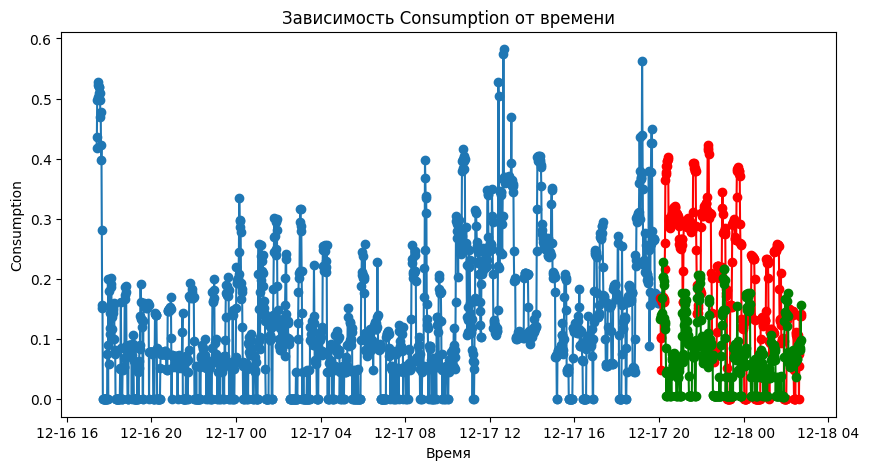

RMSE на тестовой выборке (в исходном масштабе): 0.1781


In [49]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(train_data_arima['Datetime'], train_data_arima['Global_reactive_power'], marker='o')
plt.plot(test_data_arima['Datetime'], test_data_arima['Global_reactive_power'], marker='o', color='red', label='test')
plt.plot(test_data_arima['Datetime'], forecast, marker='o', color='green', label='prediction')
plt.title('Зависимость Consumption от времени')
plt.xlabel('Время')
plt.ylabel('Consumption')
plt.show()

# Оценка RMSE на оригинальных данных
rmse = np.sqrt(mean_squared_error(test_data_arima['Global_reactive_power'], forecast))
print(f"RMSE на тестовой выборке (в исходном масштабе): {rmse:.4f}")

Вывод по точности прогноза:

1. SampleRNN

Значение MSE - **0.0360**

2. GRU

Значение MSE - **0.1068**

3. LSTM

Значение MSE - **0.1152**

4. ARIMA

Значение MSE - **0.1683**

После нормализации - **0.1781**

Таким образом, наилучший резульата у SampleRNN с большим отрывом